# Use NMF with Peak Shifting to Fit XRD Patterns
Try out our new method on some real data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multimodal.keras import (SingleModalFactorization, run_training,
                              ContinuityRegularizer, MultiRegularizer)
from scipy.interpolate import interp1d
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import InputLayer
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import os

/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lward/miniconda3/envs/multimodal/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lward/miniconda3/envs/multim

## Load in the Data
It's saved in a pickle file. We only need the diffraction patterns

In [2]:
data = pd.read_pickle(os.path.join('..', 'data.pkl.gz'))

In [3]:
xrd_patterns = np.vstack(data['xrd pattern'].apply(lambda x: x[: , 1]))

In [4]:
two_theta = data['xrd pattern'].iloc[0][:, 0]

Normalize them by the maximum intensity in the total set

In [5]:
xrd_patterns /= xrd_patterns.max()

Remove the data in the high-frequency range

In [6]:
mask = two_theta < 10

In [7]:
two_theta = two_theta[mask]

In [8]:
xrd_patterns = xrd_patterns[:, mask]

Make the data sparser, for debugging purposes

In [9]:
two_theta = two_theta[::2]

In [10]:
xrd_patterns = xrd_patterns[:, ::2]

## Make the NMF Engine
We are going to use a model with peak shifting and regularization


In [11]:
shift_reg = MultiRegularizer([L1L2(1e-8), ContinuityRegularizer(1e-6, 0)])
contrib_reg = MultiRegularizer([L1L2(1e-5), ContinuityRegularizer(1e-6, 0)])
nmf = Sequential([InputLayer(batch_input_shape=xrd_patterns.shape, name='signal'),
                  SingleModalFactorization(n_components=8, name='factorization',
                                           fit_shift=True, 
                                           component_regularizer=L1L2(l1=1e-6),
                                           contribution_regularizer=contrib_reg,
                                           shift_regularizer=shift_reg,
                                           subbatch_size=190)])

Define a loss function to weigh the error in each peak measurement by $1/y_{obs}$, in accordance with the error in the signal

In [12]:
def weighted_loss(y_true, y_pred):
    error = y_true - y_pred
    weight = 1 / y_true
    return K.mean(weight * error ** 2)
nmf.compile('adam', weighted_loss)
nmf.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
factorization (SingleModalFa (365, 255)                7880      
Total params: 7,880
Trainable params: 7,880
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
history = run_training(nmf, xrd_patterns, 10000, steps_per_epoch=1, 
                       early_stopping_patience=100,
                       early_stopping_tolerance=1e-7,
                       verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




100%|██████████| 10000/10000 [1:15:34<00:00,  2.21it/s, best_loss=0.00139, loss=0.00139]

CPU times: user 2d 2h 39min 10s, sys: 16h 44min 51s, total: 2d 19h 24min 2s
Wall time: 1h 15min 34s


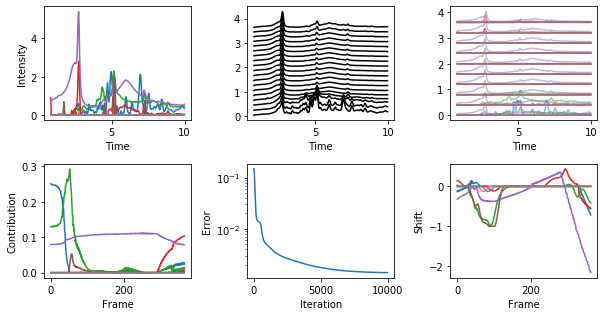

In [14]:
fig, axs = plt.subplots(2, 3)
axs = axs.flatten()

# Get the learned representation
nmf_layer = nmf.get_layer('factorization')
components = nmf_layer.get_components()
weights = nmf_layer.get_contributions()
shifted_components = K.get_value(nmf_layer.shifted_contributions)
shift_values = K.get_value(nmf_layer.shift)

# Plot the components
for comp in nmf_layer.get_components():
    axs[0].plot(two_theta, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
signal_recon = nmf.predict_on_batch(xrd_patterns)
for i, row in enumerate(signal_recon):
    if i % 20 != 0: continue
    axs[1].plot(two_theta, row + i / 100, 'k-')
    
# Plot the reconstruction, broken down into components
for comp, c in zip(shifted_components, [f'C{i}' for i in range(shifted_components.shape[0])]):
    for i, row in enumerate(comp):
        if i % 40 != 0: continue
        axs[2].plot(two_theta, row + i / 100, c, zorder=i, alpha=0.5)
    
for ax in axs[:3]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

axs[4].semilogy(history['epoch'], history['loss'])
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Error')

for shift in shift_values.T:
    axs[5].plot(shift)
axs[5].set_xlabel('Frame')
axs[5].set_ylabel('Shift')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'xrd-fit-summary.png'), dpi=320)

*Finding*: Fitting seemed to work. We have good agreeemnts with the experiemtnal data, no duplicate peaks, and reasonable shift values

### Visualize the Performance
See how good a few patterns look post-reconstruction, if the components make sense, etc

Run the reconstruction

In [15]:
%%time
reconstructed = nmf.predict_on_batch(xrd_patterns)

CPU times: user 6.89 s, sys: 1.39 s, total: 8.28 s
Wall time: 139 ms


Plot a few

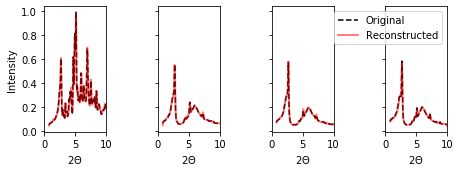

In [16]:
fig, axs = plt.subplots(1, 4, sharey=True)

chosen_ids = np.linspace(0, xrd_patterns.shape[0]-1, 5, dtype=np.int)[:-1]

for pid, ax in zip(chosen_ids, axs):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, xrd_patterns[pid], 'k--', label='Original')
    ax.plot(two_theta, reconstructed[pid], 'r-', label='Reconstructed', alpha=0.5, lw=2)

axs[0].set_ylabel('Intensity')
axs[-1].legend()
for ax in axs:
    ax.set_xlabel('$2\Theta$')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

Plot the components

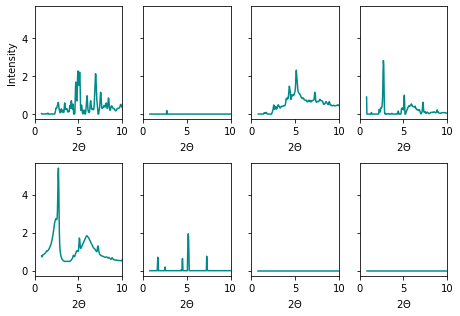

In [17]:
fig, axs = plt.subplots(2, 4, sharey=True)
axs = axs.flatten()

for pid, ax in enumerate(axs):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, components[pid, :], color='darkcyan')

axs[0].set_ylabel('Intensity')
for ax in axs:
    ax.set_xlabel('$2\Theta$')
fig.set_size_inches(6.5, 4.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'xrd-components.png'), dpi=320)

*Finding*: We find only 6 components, which I am not sure what to make of. It is at least promising that that the network "zeros-out" unneeded components

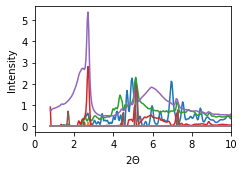

In [18]:
fig, ax = plt.subplots()

for pid in range(components.shape[0]):
    ax.set_xlim([0, 10])
    ax.plot(two_theta, components[pid, :], label=f'{pid}')

ax.set_ylabel('Intensity')
ax.set_xlabel('$2\Theta$')
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'xrd-components-alltogether.png'), dpi=320)

Plot the change in components

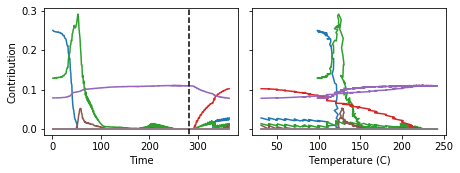

In [19]:
fig, axs = plt.subplots(1, 2, sharey=True)

for i, l in enumerate(weights.T):
    axs[0].plot(data['Seq.'], l, label=i)
axs[0].set_xlabel('Time')
#axs[0].legend()
axs[0].set_ylim(axs[0].get_ylim())
axs[0].plot([data['Seq.'].loc[data['measured temp'].idxmax()]]*2, ax.get_ylim(), 'k--')

axs[1].plot(data['measured temp'], weights)
axs[1].set_xlabel('Temperature (C)')

axs[0].set_ylabel('Contribution')
fig.set_size_inches(6.5, 2.5)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'xrd-proportions.png'), dpi=320)

*Finding*: We have a couple different types of signals. And at least 1 seems to form exclusively on cooling. 